In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.decomposition import PCA

In [2]:
dataset = "politician"

In [3]:
df_means = pd.read_csv("master/outputs/cluster_means/%s_means.csv"%dataset)
df_emb = pd.read_csv("master/outputs/embeddings/%s_embedding.csv"%dataset)
df_edges = pd.read_csv("master/data/%s_edges.csv"%dataset, index_col="node_1")
df_emb.shape

(5908, 16)

In [4]:
with open('master/outputs/assignments/%s.json'%dataset) as json_file:  
    labels = json.load(json_file)
len(labels)

5908

In [5]:
df_label = pd.DataFrame({"index" : list(labels.keys()), "label" : list(labels.values())})
df_label["index"] = df_label["index"].astype(int)
df_label = df_label.set_index("index")
df_label = df_label.sort_index()
print(df_label.shape)
df_label.head()

(5908, 1)


,label
index,
0,1
1,5
2,7
3,12
4,10


### Diffusion Modeling

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

In [12]:
def cosine(x, y):
    return x.dot(y) / (np.linalg.norm(x) * np.linalg.norm(y))

cosine(df_emb.iloc[1], df_emb.iloc[3])

-0.30574478510952025

In [13]:
def lookup_neighbor(i):
    if i in df_edges.index:
        if len(df_edges.loc[i]) == 1:
            return [df_edges.loc[i].node_2]
        return df_edges.loc[i].node_2
    return []

In [14]:
seeds = [1]

for seed in seeds: 
    neighbors = lookup_neighbor(seed)
    for nei in neighbors:
        print(seed, nei, cosine(df_emb.iloc[seed], df_emb.iloc[nei]))
        print( cosine_similarity(df_emb.iloc[seed].values.reshape(1, -1), df_emb.iloc[nei].values.reshape(1, -1))[0][0])# 

1 4413 0.9974884723008519
0.9974884723008519
1 4896 0.9984128515538626
0.9984128515538627
1 5471 0.9945242422861698
0.9945242422861698
1 3531 0.9946260411006532
0.9946260411006532
1 1965 0.9831698357962538
0.9831698357962537
1 2565 0.9861203336882424
0.9861203336882423
1 3317 0.997821762432456
0.9978217624324561
1 5565 0.9956677304241629
0.995667730424163
1 2448 0.9949684810476138
0.9949684810476139
1 955 0.9823198512929074
0.9823198512929076
1 3699 0.9965423514695567
0.9965423514695568
1 519 0.981452697271177
0.981452697271177
1 3849 0.9947623023575536
0.9947623023575536
1 5557 0.9827299777093296
0.9827299777093297
1 1618 0.9945322452970689
0.9945322452970689
1 3779 0.3871626684839132
0.3871626684839131
1 3550 0.9951758002351397
0.9951758002351399
1 3866 0.9831429459777503
0.9831429459777503
1 5729 0.9844633610423364
0.9844633610423364


In [15]:
def simulate_diffusion(seeds, iteration=10):
    df_infected = df_label.copy()
    df_infected.index = df_infected.index.astype(int)
    df_infected["infected"] = False
    df_infected.loc[seeds, 'infected'] = True

    df_history = df_label.copy()
    df_history.index = df_history.index.astype(int)
    prev = len(seeds)
    for i in range(iteration):
        df_infected_cur = df_infected[df_infected.infected==1].index
        for j, source in enumerate(df_infected_cur):
            
            if j % (len(df_emb) // 1000) == 0:
                df_history["i%i_f%i"%(i, j)] = df_infected.infected
            
            neighbors = lookup_neighbor(source)
            neighbors = list(filter(lambda x : cosine(df_emb.iloc[source], df_emb.iloc[x]) > np.random.rand(), neighbors))
            df_infected.loc[neighbors, 'infected'] = True
            
            if j % 1000 == 0:
                print("iteration %i, progress %i/%i, infected %i (%.2f%%)     "
                      %(i, j, len(df_infected_cur), sum(df_infected.infected), 
                        100 * sum(df_infected.infected) / len(np.unique(df_edges.node_2))))
                
    return df_history, df_infected

### Random Seeds

In [16]:
n_seeds = 60

In [17]:
seeds = np.random.choice(df_emb.index, n_seeds)

df_history, df_infected = simulate_diffusion(seeds)

iteration 0, progress 0/60, infected 67 (1.37%)     
iteration 1, progress 0/455, infected 455 (9.29%)     
iteration 2, progress 0/1259, infected 1261 (25.75%)     
iteration 2, progress 1000/1259, infected 1632 (33.33%)     
iteration 3, progress 0/1646, infected 1646 (33.61%)     
iteration 3, progress 1000/1646, infected 1924 (39.29%)     
iteration 4, progress 0/1950, infected 1950 (39.82%)     
iteration 4, progress 1000/1950, infected 2122 (43.33%)     
iteration 5, progress 0/2184, infected 2184 (44.60%)     
iteration 5, progress 1000/2184, infected 2330 (47.58%)     
iteration 5, progress 2000/2184, infected 2349 (47.97%)     
iteration 6, progress 0/2349, infected 2349 (47.97%)     
iteration 6, progress 1000/2349, infected 2418 (49.38%)     
iteration 6, progress 2000/2349, infected 2434 (49.70%)     
iteration 7, progress 0/2435, infected 2435 (49.72%)     
iteration 7, progress 1000/2435, infected 2454 (50.11%)     
iteration 7, progress 2000/2435, infected 2459 (50.21%) 

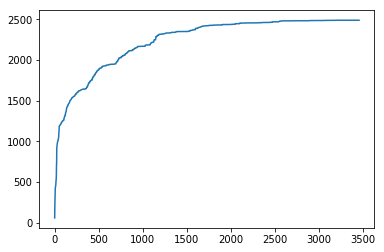

In [18]:
df_sum = df_history.drop(["label"], axis=1).sum(axis=0)
df_sum.to_csv("outputs/%s_sum_random.csv"%dataset, header=True)
plt.plot(df_sum.values)

In [19]:
df_history.iloc[:, :].to_csv("outputs/%s_random.csv"%dataset)

### Influencers

In [20]:
df_influencer = df_edges.groupby("node_1").count()
seeds = df_influencer.sort_values(["node_2"], ascending=False)[:n_seeds].index.values

df_history, df_infected = simulate_diffusion(seeds)

iteration 0, progress 0/60, infected 110 (2.25%)     
iteration 1, progress 0/1691, infected 1691 (34.53%)     
iteration 1, progress 1000/1691, infected 2463 (50.30%)     
iteration 2, progress 0/2532, infected 2532 (51.71%)     
iteration 2, progress 1000/2532, infected 2823 (57.65%)     
iteration 2, progress 2000/2532, infected 2983 (60.91%)     
iteration 3, progress 0/3003, infected 3003 (61.32%)     
iteration 3, progress 1000/3003, infected 3110 (63.51%)     
iteration 3, progress 2000/3003, infected 3214 (65.63%)     
iteration 3, progress 3000/3003, infected 3255 (66.47%)     
iteration 4, progress 0/3255, infected 3255 (66.47%)     
iteration 4, progress 1000/3255, infected 3308 (67.55%)     
iteration 4, progress 2000/3255, infected 3366 (68.74%)     
iteration 4, progress 3000/3255, infected 3385 (69.12%)     
iteration 5, progress 0/3386, infected 3386 (69.14%)     
iteration 5, progress 1000/3386, infected 3422 (69.88%)     
iteration 5, progress 2000/3386, infected 3434

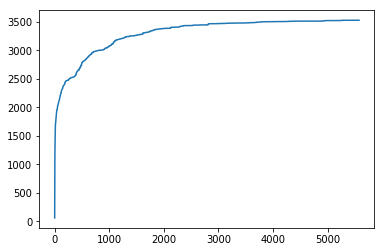

In [21]:
df_sum = df_history.drop(["label"], axis=1).sum(axis=0)
df_sum.to_csv("outputs/%s_sum_influencer.csv"%dataset, header=True)
plt.plot(df_sum.values)

In [22]:
df_history.iloc[:, :].to_csv("outputs/%s_influencer.csv"%dataset)

### Cluster Random Seeds

In [23]:
n_classes = len(np.unique(df_label.label))

In [24]:
for target in range(n_classes):
    print(target, "cluster size", sum(df_label.label==target))

0 cluster size 184
1 cluster size 319
2 cluster size 359
3 cluster size 154
4 cluster size 357
5 cluster size 238
6 cluster size 284
7 cluster size 205
8 cluster size 377
9 cluster size 203
10 cluster size 375
11 cluster size 330
12 cluster size 537
13 cluster size 552
14 cluster size 217
15 cluster size 163
16 cluster size 253
17 cluster size 249
18 cluster size 115
19 cluster size 437


In [25]:
seeds = []
for target in range(n_classes):
    df_cluster = df_label[df_label.label==target]
    cluster_n_seeds = round(n_seeds * len(df_cluster) / len(df_emb))
    seeds += list(np.random.choice(df_cluster.index, cluster_n_seeds, replace=False))

In [26]:
seeds = [int(i) for i in seeds]
len(seeds)

61

In [27]:
df_history, df_infected = simulate_diffusion(seeds)

iteration 0, progress 0/61, infected 67 (1.37%)     
iteration 1, progress 0/378, infected 378 (7.72%)     
iteration 2, progress 0/1320, infected 1320 (26.96%)     
iteration 2, progress 1000/1320, infected 1813 (37.02%)     
iteration 3, progress 0/1827, infected 1827 (37.31%)     
iteration 3, progress 1000/1827, infected 2057 (42.01%)     
iteration 4, progress 0/2084, infected 2084 (42.56%)     
iteration 4, progress 1000/2084, infected 2203 (44.99%)     
iteration 4, progress 2000/2084, infected 2227 (45.48%)     
iteration 5, progress 0/2228, infected 2228 (45.50%)     
iteration 5, progress 1000/2228, infected 2304 (47.05%)     
iteration 5, progress 2000/2228, infected 2320 (47.38%)     
iteration 6, progress 0/2320, infected 2320 (47.38%)     
iteration 6, progress 1000/2320, infected 2384 (48.68%)     
iteration 6, progress 2000/2320, infected 2393 (48.87%)     
iteration 7, progress 0/2393, infected 2393 (48.87%)     
iteration 7, progress 1000/2393, infected 2422 (49.46%) 

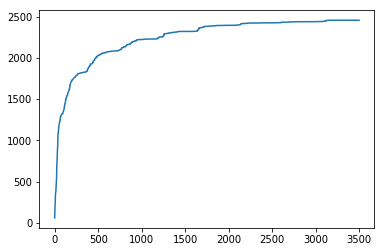

In [28]:
df_sum = df_history.drop(["label"], axis=1).sum(axis=0)
df_sum.to_csv("outputs/%s_sum_cluster_random.csv"%dataset, header=True)
plt.plot(df_sum.values)

In [29]:
df_history.iloc[:, :].to_csv("outputs/%s_cluster_random.csv"%dataset)

### Cluster Influencer

In [30]:
seeds = []
for target in range(n_classes):
    idxs = df_label[df_label.label == target].index
    df_cluster = df_edges.loc[list(map(int, idxs))]
    
    df_influencer = df_cluster.groupby("node_1").count()
    
    seeds += list(df_influencer.sort_values(["node_2"], ascending=False)[:int(n_seeds / n_classes)].index.values)
len(seeds)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.


60

In [31]:
df_history, df_infected = simulate_diffusion(seeds)

iteration 0, progress 0/60, infected 93 (1.90%)     
iteration 1, progress 0/2262, infected 2262 (46.19%)     
iteration 1, progress 1000/2262, infected 3161 (64.55%)     
iteration 1, progress 2000/2262, infected 3355 (68.51%)     
iteration 2, progress 0/3369, infected 3369 (68.80%)     
iteration 2, progress 1000/3369, infected 3550 (72.49%)     
iteration 2, progress 2000/3369, infected 3661 (74.76%)     
iteration 2, progress 3000/3369, infected 3694 (75.43%)     
iteration 3, progress 0/3701, infected 3701 (75.58%)     
iteration 3, progress 1000/3701, infected 3754 (76.66%)     
iteration 3, progress 2000/3701, infected 3781 (77.21%)     
iteration 3, progress 3000/3701, infected 3801 (77.62%)     
iteration 4, progress 0/3803, infected 3803 (77.66%)     
iteration 4, progress 1000/3803, infected 3812 (77.84%)     
iteration 4, progress 2000/3803, infected 3824 (78.09%)     
iteration 4, progress 3000/3803, infected 3829 (78.19%)     
iteration 5, progress 0/3832, infected 3832 

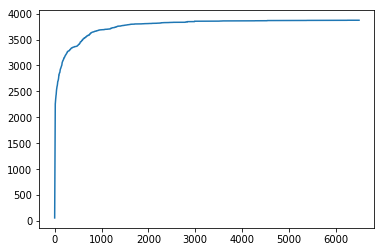

In [32]:
df_sum = df_history.drop(["label"], axis=1).sum(axis=0)
df_sum.to_csv("outputs/%s_sum_cluster_influencer.csv"%dataset, header=True)
plt.plot(df_sum.values)

In [33]:
df_history.iloc[:, :].to_csv("outputs/%s_cluster_influencer.csv"%dataset)

### Stratified Sampling by Influence

In [34]:
# df_influencer = df_edges.groupby("node_1").count().sort_values(["node_2"], ascending=False)
# df_influencer["influence"] = 100 * df_influencer.node_2 / len(df_label)
# len(df_influencer)

In [35]:
# n_strata = 32
# _ = plt.hist(df_influencer.node_2, bins=n_strata)
# strata_size, strata_bound = _[0], _[1]
# # plt.close()

In [36]:
# strata_sizes = list(map(round, strata_size))
# strata_bounds = list(map(round, strata_bound))

In [37]:
# seeds = []
# for i in range(n_strata):
#     l, r = strata_bounds[i], strata_bounds[i + 1]
#     strata_size = int(strata_sizes[i])
#     df_strata = df_influencer[(df_influencer.node_2 > l) & (df_influencer.node_2 < r)]
#     cluster_n_seeds = round(n_seeds * strata_size / len(df_influencer))
#     cluster_seeds = list(df_strata[:cluster_n_seeds].index.values)
    
#     seeds += cluster_seeds
# print(len(seeds))

In [38]:
# df_history, df_infected = simulate_diffusion(seeds, iteration=5)

In [39]:
# df_sum = df_history.drop(["label"], axis=1).sum(axis=0)
# df_sum.to_csv("outputs/%s_sum_cluster_influencer.csv"%dataset, header=True)
# plt.plot(df_sum.values)